In [44]:
import pandas as pd
import numpy as np
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.linear_model import SGDClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline
from pprint import pprint
from time import time
import logging
from sklearn.naive_bayes import MultinomialNB
import seaborn as sn
import matplotlib.pyplot as plt
import sklearn.metrics as metrics
from sklearn.metrics import average_precision_score
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import plot_precision_recall_curve

In [45]:
X_train = pd.read_csv('../data/interim/X-train.csv', usecols = ['question_text'], squeeze=True)
y_train = pd.read_csv('../data/interim/y-train.csv', usecols = ['target'], squeeze=True)
X_test = pd.read_csv('../data/interim/X-test.csv', usecols = ['question_text'], squeeze=True)
y_test = pd.read_csv('../data/interim/y-test.csv', usecols = ['target'], squeeze=True)

In [46]:
X_train.head()

0                   Can I get pregnant by dry humping?
1    Can I divade project in different git submodul...
2                 How can I donate bone marrow in UAE?
3     What are the best books about negative thinking?
4             Why does Texas have high property taxes?
Name: question_text, dtype: object

In [47]:
y_train.head()

0    0
1    0
2    0
3    0
4    0
Name: target, dtype: int64

Let's check ratio of '1's tp '0's. 

In [48]:
np.mean(y_test)

0.06186261599240499

In [49]:
def calculate_accuracy(true_y, predicted_y):
    print('Accuracy: ', np.mean(predicted_y==true_y))

In [50]:
def plot_confusion_matrix(true_y, predicted_y):
    df = pd.DataFrame(data = {'y_Actual': true_y,
                              'y_Predicted': predicted_y
                             }, columns=['y_Actual','y_Predicted'])
    confusion_matrix = pd.crosstab(df['y_Actual'], df['y_Predicted'], 
                                   rownames=['Actual'], colnames=['Predicted'])
    sn.heatmap(confusion_matrix, annot=True)
    plt.show()

In [51]:
def plot_roc(model, X_test, y_test):
    # calculate the fpr and tpr for all thresholds of the classification
    probs = model.predict_proba(X_test)
    preds = probs[:,1]
    fpr, tpr, threshold = metrics.roc_curve(y_test, preds)
    roc_auc = metrics.auc(fpr, tpr)
    
    plt.title('Receiver Operating Characteristic')
    plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
    plt.legend(loc = 'lower right')
    plt.plot([0, 1], [0, 1],'r--')
    plt.xlim([0, 1])
    plt.ylim([0, 1])
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
    plt.show()

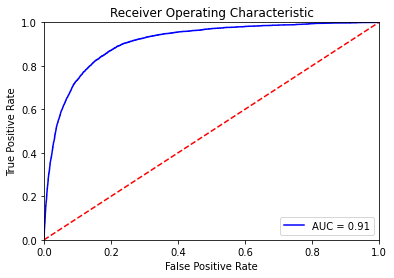

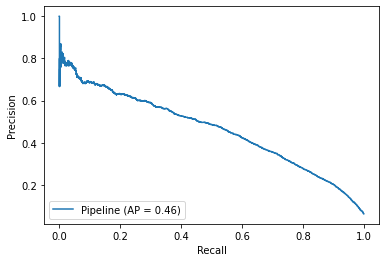

Accuracy:  0.9406639512449085


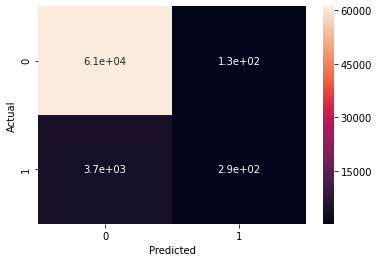

In [55]:
# Logistic regression
log_clf = Pipeline([
    ('vect', CountVectorizer()),
    ('tfidf', TfidfTransformer()),
    ('clf', SGDClassifier(loss='log')),
])
log_clf.fit(X_train, y_train)

plot_roc(log_clf, X_test, y_test)

plot_precision_recall_curve(log_clf, X_test, y_test)
plt.show()

log_predicted = log_clf.predict(X_test)
calculate_accuracy(y_test,log_predicted)
plot_confusion_matrix(y_test,log_predicted)


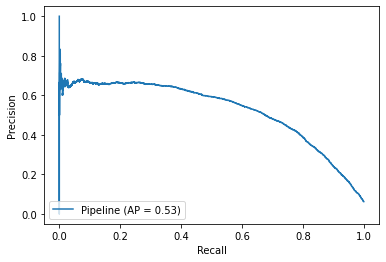

Accuracy:  0.9389795730866995


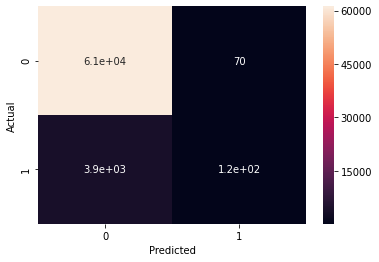

In [56]:
# SVM
svm_clf = Pipeline([
    ('vect', CountVectorizer()),
    ('tfidf', TfidfTransformer()),
    ('clf', SGDClassifier(loss='hinge')),
])
svm_clf.fit(X_train, y_train)

#plot_roc(svm_clf, X_test, y_test)

plot_precision_recall_curve(svm_clf, X_test, y_test)
plt.show()

svm_predicted = svm_clf.predict(X_test)
calculate_accuracy(y_test, svm_predicted)
plot_confusion_matrix(y_test, svm_predicted)

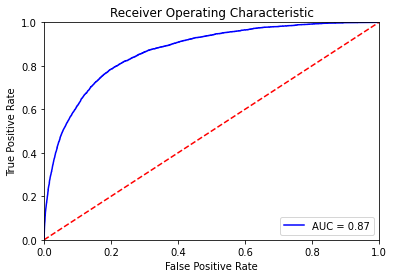

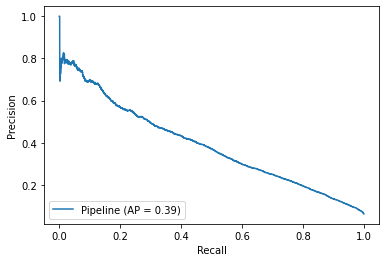

Accuracy:  0.9386733225124797


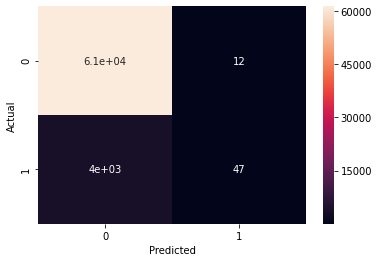

In [57]:
# Naive Bayes
naive_bayes_clf = Pipeline([
    ('vect', CountVectorizer()),
    ('tfidf', TfidfTransformer()),
    ('clf', MultinomialNB()),
])
naive_bayes_clf.fit(X_train, y_train)

plot_roc(naive_bayes_clf, X_test, y_test)

plot_precision_recall_curve(naive_bayes_clf, X_test, y_test)
plt.show()

naive_bayes_predicted = naive_bayes_clf.predict(X_test)
calculate_accuracy(y_test, naive_bayes_predicted)
plot_confusion_matrix(y_test, naive_bayes_predicted)

In [14]:
from sklearn.base import BaseEstimator
class DummyClf(BaseEstimator):
    def fit(self): pass
    def score(self): pass

In [15]:
pipeline = Pipeline([
    ('vect', CountVectorizer()),
    ('tfidf', TfidfTransformer()),
    ('clf', DummyClf()),
])

parameters = [
    {
        'vect__stop_words': ('english', None,),
        'vect__lowercase': (True, None,),
        'clf': [SGDClassifier()], # SVM if hinge loss / logreg if log loss
        'clf__penalty': ('l2', 'elasticnet', 'l1'),
        #'clf__max_iter': [50, 80],
        'clf__penalty': ('l1','l2','elasticnet'),
        'clf__alpha': (1e-3, 1e-4, 1e-5, 1e-6),
        'clf__tol': [1e-4],
        'clf__loss': ['hinge', 'log'],
    },
    {
        'vect__stop_words': ('english', None,),
        'vect__lowercase': (True, None,),
        'clf': [MultinomialNB()],
        'clf__alpha': (1e-3, 1e-4, 1e-5, 1e-6),
    },
]

gscv = GridSearchCV(pipeline, parameters, cv=5, scoring='average_precision')

In [16]:
print("Performing grid search...")
print("pipeline:", [name for name, _ in pipeline.steps])
print("parameters:")
pprint(parameters)
t0 = time()
gscv.fit(X_train['question_text'], y_train)
print("done in %0.3fs" % (time() - t0))
print()

print("Best score: %0.3f" % gscv.best_score_)
print("Best parameters set:")
best_parameters = gscv.best_estimator_.get_params()
print(best_parameters['vect'])
print(best_parameters['tfidf'])
print(best_parameters['clf'])

Performing grid search...
pipeline: ['vect', 'tfidf', 'clf']
parameters:
[{'clf': [SGDClassifier(alpha=0.0001, average=False, class_weight=None,
              early_stopping=False, epsilon=0.1, eta0=0.0, fit_intercept=True,
              l1_ratio=0.15, learning_rate='optimal', loss='hinge',
              max_iter=1000, n_iter_no_change=5, n_jobs=None, penalty='l2',
              power_t=0.5, random_state=None, shuffle=True, tol=0.001,
              validation_fraction=0.1, verbose=0, warm_start=False)],
  'clf__alpha': (0.001, 0.0001, 1e-05, 1e-06),
  'clf__loss': ['hinge', 'log'],
  'clf__penalty': ('l1', 'l2', 'elasticnet'),
  'clf__tol': [0.0001],
  'vect__lowercase': (True, None),
  'vect__stop_words': ('english', None)},
 {'clf': [MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True)],
  'clf__alpha': (0.001, 0.0001, 1e-05, 1e-06),
  'vect__lowercase': (True, None),
  'vect__stop_words': ('english', None)}]
done in 1337.967s

Best score: 0.580
Best parameters set:
CountVector

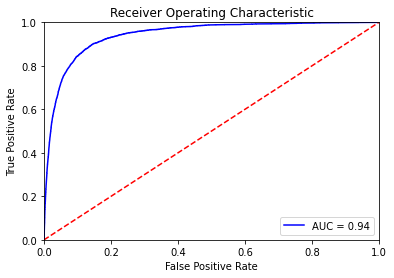

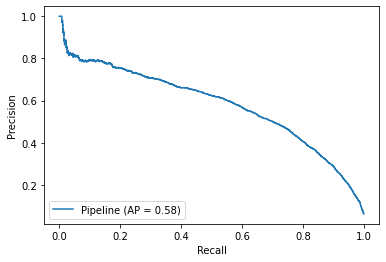

Accuracy:  0.9507702201941629


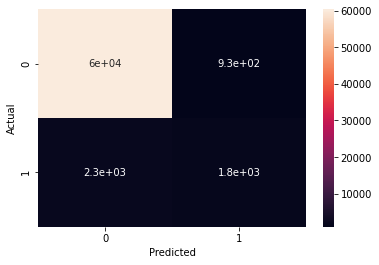

In [65]:
best_model  = gscv.best_estimator_
best_model.fit(X_train, y_train)

plot_roc(best_model, X_test, y_test)

plot_precision_recall_curve(best_model, X_test, y_test)
plt.show()

y_scores = best_model.predict_proba(X_test)[:, 1]
p, r, thresholds = precision_recall_curve(y_test, y_scores)
l = len(thresholds)
p_r_th_df = pd.DataFrame({'Precision': p[0:l], 'Recall':r[0:l], 'Threshold':thresholds[0:l]})

best_model_predicted = best_model.predict(X_test)
calculate_accuracy(y_test, best_model_predicted)
plot_confusion_matrix(y_test, best_model_predicted)

In [59]:
p_r_th_df.head(10)

,Precision,Recall,Threshold
0,0.062155,1.000000,0.000144
1,0.062140,0.999752,0.000144
2,0.062141,0.999752,0.000144
3,0.062142,0.999752,0.000144
4,0.062143,0.999752,0.000144
5,0.062144,0.999752,0.000145
6,0.062145,0.999752,0.000145
7,0.062146,0.999752,0.000145
8,0.062147,0.999752,0.000146
9,0.062148,0.999752,0.000146


In [60]:
p_r_th_df.tail(10)

,Precision,Recall,Threshold
64812,1.0,0.002475,0.997655
64813,1.0,0.002228,0.997870
64814,1.0,0.001980,0.998072
64815,1.0,0.001733,0.998102
64816,1.0,0.001485,0.998234
64817,1.0,0.001238,0.998509
64818,1.0,0.000990,0.998990
64819,1.0,0.000743,0.999110
64820,1.0,0.000495,0.999608
64821,1.0,0.000248,0.999638


In [61]:
coefs = best_model.named_steps['clf'].coef_[0]

pipe = Pipeline([('vect', gscv.best_estimator_['vect']),
                 ('tfidf', gscv.best_estimator_['tfidf'])]).fit(X_train)

features = pipe['vect'].get_feature_names()

dfx = pd.DataFrame({'features':features, 'coef':coefs})

In [62]:
dfx.sort_values(by=['coef'], inplace=True)

In [63]:
dfx.head(10)

,features,coef
70818,what,-11.476569
31509,how,-4.544269
4888,amazon,-4.025125
54500,regret,-3.943494
33474,inhabit,-3.905239
10295,books,-3.764579
14996,comfortable,-3.673742
19076,describe,-3.548678
50892,potential,-3.447470
70889,which,-3.321830


In [64]:
dfx.tail(10)

,features,coef
38347,liberals,6.948174
53589,rape,6.985673
33147,indians,6.997132
18745,democrats,7.023253
12489,castrating,7.035091
26733,fuck,7.215146
43885,muslims,7.564962
12490,castration,10.323210
12487,castrate,10.915298
12488,castrated,12.347841
